<a href="https://colab.research.google.com/github/arputtick/geographic_centers/blob/master/Geographic_Center.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Computing the Geographic Center of Białowieski Park Narodowy

In this Jupyter Notebook, we apply the methods of [1] to compute the geographic center of Bialowieski Park Narodowy in Poland.

The GitHub repository for the project can be found [here](https://github.com/arputtick/geographic_centers).

---

The method can be applied to any contingent landmass and can even be adapted for landmasses composed a several disconnected parts (see [1]).



**Input:** Longitude and latitude coordinates of $n$ points on the border of the landmass (labeled clockwise from 0 to $n-1$). The points should be distributed along the entire border and $n$ should be large enough so that the polygon formed by connecting them is a good approximation of the shape of the landmass.

**Output:** Approximation of the *geographic center* of the landmass. The geographic center is the point that is simultaneously as close as possible to all other points in the region.

The main diffculty is that the landmass lies on the surface of a sphere. However, there are simple ways to compute the center of a flat 2D polygon. The idea is two find a good way to project from the sphere onto a flat plane so that the center of the resulting polygon is a good approximation of the center of the shape on the sphere surface.

---

We begin by installing and importing the relevant Python libraries:

In [1]:
pip install geopandas

     |████████████████████████████████| 972kB 3.3MB/s 
     |████████████████████████████████| 10.9MB 17.1MB/s 
     |████████████████████████████████| 14.8MB 311kB/s 


In [2]:
import pandas as pd
import geopandas as gpd
import numpy as np
import math as m
import matplotlib.pyplot as plt

---
# The boundary coordinate data
The input data consists of the longitude and latitude coordinates of over 608 points along the border of the park, given in clockwise order, and stored in a .csv file.

The data was compiled by Dani Ploeger and can be found [here](https://github.com/arputtick/geographic_centers/raw/master/Bialowieza-coordinates.csv).

In [3]:
## Load the data from the project's github repo.
data_url = 'https://github.com/arputtick/geographic_centers/raw/master/Bialowieza-coordinates.csv'

boundary_data = pd.read_csv(data_url)
boundary_data.head(5)

,shapeid,partid,x,y,WDPAID,WDPA_PID,PA_DEF,NAME,ORIG_NAME,DESIG,DESIG_ENG,DESIG_TYPE,IUCN_CAT,INT_CRIT,MARINE,REP_M_AREA,GIS_M_AREA,REP_AREA,GIS_AREA,NO_TAKE,NO_TK_AREA,STATUS,STATUS_YR,GOV_TYPE,OWN_TYPE,MANG_AUTH,MANG_PLAN,VERIF,METADATAID,SUB_LOC,PARENT_ISO,ISO3,vertex_index,vertex_part,vertex_part_ring,vertex_part_index,distance,angle
0,0,NaN,23.909080,52.722164,854.0,854,1,Białowieski Park Narodowy,Białowieski Park Narodowy,Park Narodowy,National Park,National,II,Not Applicable,0,0.0,0.0,105.2931,104.974307,Not Applicable,0.0,Designated,1932,Federal or national ministry or agency,Not Reported,Not Reported,Not Reported,State Verified,1839,Not Reported,POL,POL,171,3,0,0,0.184376,258.388085
1,1,NaN,23.908281,52.722000,854.0,854,1,Białowieski Park Narodowy,Białowieski Park Narodowy,Park Narodowy,National Park,National,II,Not Applicable,0,0.0,0.0,105.2931,104.974307,Not Applicable,0.0,Designated,1932,Federal or national ministry or agency,Not Reported,Not Reported,Not Reported,State Verified,1839,Not Reported,POL,POL,172,3,0,1,0.185192,258.719830
2,2,NaN,23.907534,52.721855,854.0,854,1,Białowieski Park Narodowy,Białowieski Park Narodowy,Park Narodowy,National Park,National,II,Not Applicable,0,0.0,0.0,105.2931,104.974307,Not Applicable,0.0,Designated,1932,Federal or national ministry or agency,Not Reported,Not Reported,Not Reported,State Verified,1839,Not Reported,POL,POL,173,3,0,2,0.185953,259.155866
3,3,NaN,23.907122,52.721777,854.0,854,1,Białowieski Park Narodowy,Białowieski Park Narodowy,Park Narodowy,National Park,National,II,Not Applicable,0,0.0,0.0,105.2931,104.974307,Not Applicable,0.0,Designated,1932,Federal or national ministry or agency,Not Reported,Not Reported,Not Reported,State Verified,1839,Not Reported,POL,POL,174,3,0,3,0.186371,259.259457
4,4,NaN,23.907048,52.721763,854.0,854,1,Białowieski Park Narodowy,Białowieski Park Narodowy,Park Narodowy,National Park,National,II,Not Applicable,0,0.0,0.0,105.2931,104.974307,Not Applicable,0.0,Designated,1932,Federal or national ministry or agency,Not Reported,Not Reported,Not Reported,State Verified,1839,Not Reported,POL,POL,175,3,0,4,0.186447,259.257610


The 'x' column consists of longitude coordinates and the 'y' column of latitude coordinates.

In [10]:
## Extract the longitude and latitude columns.
boundary_points = boundary_data[['x', 'y']]
boundary_points.head(5)

,x,y
0,23.909080,52.722164
1,23.908281,52.722000
2,23.907534,52.721855
3,23.907122,52.721777
4,23.907048,52.721763


## Visualizing the data
We can use the GeoPandas library to plot the data onto a map of the park. The map data was downloaded from [protected planet](https://www.protectedplanet.net/bialowieski-park-narodowy-national-park?fbclid=IwAR3T4x6XKiKiD4IBJdcX-SVobAKZrHIYu5ktDAMcBGSJU4w_77rGFbaCsaY) and can also be found the project GitHub repo.


In [14]:
## Locations of map data files (there are 3 and they have to be merged).
url_1 = 'https://github.com/arputtick/geographic_centers/raw/master/WDPA_WDOECM_protected_area_854-shapefile0.zip'
url_2 = 'https://github.com/arputtick/geographic_centers/raw/master/WDPA_WDOECM_protected_area_854-shapefile1.zip'
url_3 = 'https://github.com/arputtick/geographic_centers/raw/master/WDPA_WDOECM_protected_area_854-shapefile2.zip'

In [15]:
## Load the map data into the notebook.
gdf1 = gpd.read_file(url_1)
gdf2 = gpd.read_file(url_2)
gdf3 = gpd.read_file(url_3)

## Merge the three files into a single GeoDataFrame.
gdf = gpd.GeoDataFrame(pd.concat([gdf1, gdf2, gdf3]))

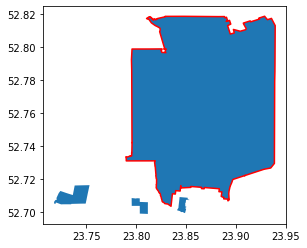

In [16]:
## Plot the map data and boundary point data (the latter is represented
## by a red line connecting the points from the data table).
map = gdf.plot()
map.plot(boundary_points['x'], boundary_points['y'], c = 'red')

**Note:** As can be seen in the image, our computation ignores the small disconnected landmasses outside of the main park area.

## Converting from degrees to radians
Since the math library sine and cosine functions take radians (on a 0-$2\pi$ scale) as input instead of degrees (on a 0-360$^\circ$ scale), we have to convert the longitudes and latitudes to radians.

In [11]:
## Convert longitude and latitude to radians.
x_rads = boundary_points['x'] * 1/360 * 2 * m.pi
y_rads = boundary_points['y'] * 1/360 * 2 * m.pi

---
# Algorithm for Computing the Geographic Center

The algorithm is composed of the following steps (which we will describe in further detail as they are carried out).

1. Make an initial guess $(\phi_0,\gamma_0)$ for the longitude $\phi_0$ and latitude $\gamma_0$ of the geographic center.

2. Compute the image of each of the boundary points under the *Azimuthal Equidistant Projection* centered at the point $(\phi_0,\gamma_0)$. This projects the shape from the surface of the sphere onto a two-dimensional plane in a way that "preserves distances."

3. Compute the center point $(x_c, y_c)$ of the projected flat 2D polygon.

4. Compute the longitude and latitude $(\phi_c, \gamma_c)$ corresponding to $(x_c,y_c).$

5. Repeat with $(\phi_0,\gamma_0) = (\phi_c,\gamma_c)$.

The algorithm converges to $(\phi_{cent},\gamma_{cent})$, the longitutde-latitude coordinates of the geographic center.




---
## 1. Make an initial guess  $(𝜙_0,𝛾_0)$  for the longitude  $𝜙_0$  and latitude  $𝛾_0$  of the geographic center.

A simple way to make our initial guess is to draw the smallest rectangle (bounding box) containing the park and choose $(\phi_0,\gamma_0)$ to be the coordinates of the center of the rectangle.

In [12]:
## Find the coordinates of the corners of the bounding box
## by find the maximum and minimum longitudes resp. latitudes
## occuring amongst the boundary points.
BBox = (x_rads.min(),x_rads.max(),y_rads.min(),y_rads.max())

## Initialize phi and gamma at center of the bounding box.
phi = np.mean([BBox[0],BBox[1]])
gamma = np.mean([BBox[2],BBox[3]])

print(phi,gamma)

0.4165162875836439 0.9208566077009757


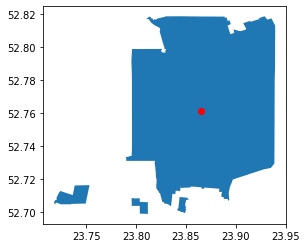

In [25]:
## Visualize the inital guess on the map
phi_deg = phi * 360 / (2 * m.pi)
gamma_deg = gamma * 360 / (2 * m.pi)

map = gdf.plot()
map.scatter(phi_deg,gamma_deg, c = 'red')

Since the park is pretty close to rectangular, this is already a good guess.

---

## 2. Compute the image of each of the boundary points under the Azimuthal Equidistant Projection centered at the point  $(𝜙_0,𝛾_0)$.

For details about the Azimuthal Equidistant Projection (AEP), see [2]. The AEP requires a center point $p_0 =(\phi_0,\gamma_0)$ in longitude-latitude coordinates. It is a map from the sphere to the flat plane
$$P\colon S\setminus\{\overline{p_0}\}\to \mathbb{R}^2,$$
where $S$ denotes the sphere and $\overline{p_0}$ is the point on the opposite end of the sphere from $p_0$.

It satisfies $P(p_0) = (0,0)$. For another point $p = (\phi,\gamma)$ on the sphere, the image $P(p)\in\mathbb{R}^2$ satisfies the property that the distance between $P(p)$ and $(0,0)$ in $\mathbb{R}^2$ is equal to the distance between $p$ and $p_0$ on the sphere surface.

Explicitly, for $(\phi,\gamma)\in S\setminus\{\overline{p}\}$, the image $P(\phi,\gamma) = (x,y)$ is given by:

$$x = -k \cos(\phi)\sin(\gamma - \gamma_0),$$

$$y = k\big[\cos(\phi_0)\sin(\phi) -\sin(\phi_0)\cos(\phi)\cos(\gamma -\gamma_0)\big],$$

where $k = c/\sin(c),$ with
$$c = \cos^{-1}\big(\sin(\phi_0)\sin(\phi) + \cos(\phi_0)\cos(\phi)\cos(\gamma-\gamma_0)\big).$$

**Note:** This equations in [1] are not correctly written. See [2] for the correct equations. We also add a minus sign in the equation for $x$ so that the projection has the same orientation as the original shape. Without this the algorithm diverges.

The code to computer the AEP of the boundary points is given by:

In [20]:
## Compute azimuthal equidistant projection of boundary points.

proj_points = [] # initialize list of projected points (x,y)

for bd_point in zip(x_rads,y_rads):
    cos_c = m.sin(phi) * m.sin(bd_point[0]) + m.cos(phi) * m.cos(bd_point[0]) * m.cos(bd_point[1] - gamma)
    c = m.acos(cos_c)
    k = c/m.sin(c)
    x = (-k) * m.cos(phi) * m.sin(gamma - bd_point[1])
    y = k * (m.cos(phi) * m.sin(bd_point[0]) - m.sin(phi) * m.cos(bd_point[0]) * m.cos(gamma - bd_point[1]))
    proj_points.append([x,y]) # add image of boundary point to the list

We can visualize the image of the boundary points on the flat plane as follows:

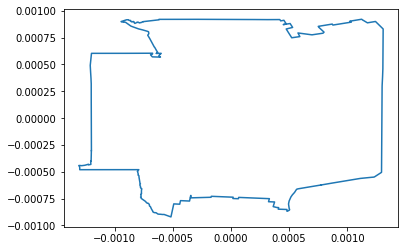

In [22]:
## Plot the image of the boundary points under AEP

x, y = zip(*proj_points)
x = np.array(x)
y = np.array(y)
plt.plot(y,x)

---
## 3. Compute the center point $(x_c,y_c)$ of the projected flat 2D polygon

The formula for computing the center $(x_c, y_c)$ of the polygon is [1] given by:

$$x_c = \frac{1}{6A}\Big[\sum_{i=0}^{n-1}(x_i + x_{i+1})(x_{i}y_{i+1}-x_{i+1}y_i)\Big],$$

$$y_c = \frac{1}{6A}\Big[\sum_{i=0}^{n-1}(y_i + y_{i+1})(x_{i}y_{i+1}-x_{i+1}y_i)\Big],$$

where $A$ is the area of the polygon, given by:
$$A = \frac{1}{2}\Big[\sum_{i=0}^{n-1}(x_{i}y_{i+1}-x_{i+1}y_i)\Big].$$


In [26]:
## Compute the center of the projected polygon
n = len(proj_points)

area_terms = []
x_terms = []
y_terms = []
for i in range(n-1):
    area_term = x[i] * y[i+1] - x[i+1] * y[i]
    area_terms.append(area_term)

    x_term = (x[i] + x[i+1]) * area_term
    y_term = (y[i] + y[i+1]) * area_term

    x_terms.append(x_term)
    y_terms.append(y_term)

area = 0.5 * np.sum(area_terms)
x_cent = np.sum(x_terms) / (6 * area)
y_cent = np.sum(y_terms) / (6 * area)

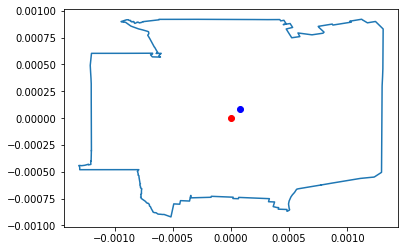

In [28]:
## Plot the computed center point (blue) as well as the
## initial guess (red).

plt.plot(y,x)
plt.scatter(0,0, c = 'red') # initial guess
plt.scatter(y_cent, x_cent, c = 'blue') # actual center of polygon

---
## 4. Compute the longitude and latitude  $(𝜙_c,𝛾_c)$  corresponding to  $(𝑥_c,𝑦_c)$.

We now have to do the AEP in reverse to find the longitude-latitude coordinates corresponding to the center we found in the previous step.

For $(x,y)\in\mathbb{R}^2\setminus \{(0,0)\}$, the inverse $(\phi,\gamma) = P^{-1}(x,y)$ on the sphere is given by:
$$\phi = \sin^{-1}\big(\cos(\rho) \sin(\phi_0) + (y\sin(\rho) \cos(\phi_0)/\rho)\big),$$

$$\gamma = \gamma_0 + \tan^{-1}\Big(\frac{x\sin(\rho)}{\rho\cos(\phi_0)\cos(\rho)-y\sin(\phi_0)\sin(\rho)}\Big),$$

where
$$\rho = \sqrt{x^2 + y^2}.$$


In [31]:
## Project the center point back to the sphere surface

rho = (x_cent**2 + y_cent**2)**(1/2)

# longitude of new center
phi_new = m.asin(m.cos(rho) * m.sin(phi) + (y_cent * m.sin(rho) * m.cos(phi)/rho))
# QUESTION: Should rho be inside or outside the cos at the end?

# latitude of new center
denom = rho * m.cos(phi) * m.cos(rho) - y_cent * m.sin(phi) * m.sin(rho)
numer = x_cent * m.sin(rho)
diff = m.atan(numer/denom)
gamma_new = gamma  + diff

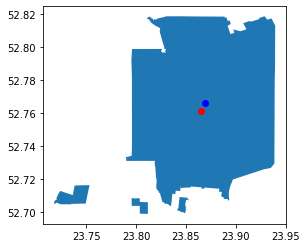

In [32]:
## Visualize on the map red = initial guess, blue = new guess
map = gdf.plot()
map.scatter(phi_deg,gamma_deg, c = 'red')

phi_new_deg = phi_new * 360 / (2 * m.pi)
gamma_new_deg = gamma_new * 360 / (2 * m.pi)
map.scatter(phi_new_deg, gamma_new_deg, c = 'blue')


---
## 5. Repeat with $(\phi_0,\gamma_0) = (\phi_c,\gamma_c)$.

We now put everything together and iterate the above process until convergence to the geographic center. In this case convergence occurs quickly, but we run the code for 1000 iterations.

In [35]:
### Code for entire algorithm from start to finish


## Find the coordinates of the corners of the bounding box.
BBox = (x_rads.min(),x_rads.max(),y_rads.min(),y_rads.max())

## Initialize phi and gamma at center of the bounding box.
phi = np.mean([BBox[0],BBox[1]])
gamma = np.mean([BBox[2],BBox[3]])


## Start of loop.

# List keeping track of center points
centers = [[phi,gamma]]
num_iter = 1000
for iter in range(num_iter):
    # Compute azimuthal equidistant projection of boundary points
    proj_points = []
    for bd_point in zip(x_rads,y_rads):
        cos_c = m.sin(phi) * m.sin(bd_point[0]) + m.cos(phi) * m.cos(bd_point[0]) * m.cos(bd_point[1] - gamma)
        c = m.acos(cos_c)
        k = c/m.sin(c)
        x = k * m.cos(phi) * m.sin(gamma - bd_point[1])
        y = k * (m.cos(phi) * m.sin(bd_point[0]) - m.sin(phi) * m.cos(bd_point[0]) * m.cos(gamma - bd_point[1]))
        proj_points.append([x,y])

    # Compute the center of the projected polygon
    n = len(proj_points)
    x, y = zip(*proj_points)
    x = np.array(x)
    y = np.array(y)
    area_terms = []
    x_terms = []
    y_terms = []
    for i in range(n-1):
        area_term = x[i] * y[i+1] - x[i+1] * y[i]
        area_terms.append(area_term)

        x_term = (x[i] + x[i+1]) * area_term
        y_term = (y[i] + y[i+1]) * area_term

        x_terms.append(x_term)
        y_terms.append(y_term)

    area = 0.5 * np.sum(area_terms)
    x_cent = np.sum(x_terms) / (6 * area)
    y_cent = np.sum(y_terms) / (6 * area)

    # Project the center point back to the sphere surface
    rho = (x_cent**2 + y_cent**2)**(1/2)

    # longitude of new center
    phi_new = m.asin(m.cos(rho) * m.sin(phi) + (y_cent * m.sin(rho) * m.cos(phi)/rho))

    # latitude of new center
    denom = rho * m.cos(phi) * m.cos(rho) - y_cent * m.sin(phi) * m.sin(rho)
    numer = -x_cent * m.sin(rho)
    diff = m.atan(numer/denom)
    gamma_new = gamma  + diff

    centers.append([phi_new, gamma_new])

    phi = phi_new
    gamma = gamma_new

phi_cent, gamma_cent = centers[num_iter-1]
phi_cent_deg = phi_cent * 360 / (2 * m.pi)
gamma_cent_deg = gamma_cent * 360 / (2 * m.pi)
print('Longitude and Latitude of Geographical Center:', phi_cent_deg, gamma_cent_deg)

Longitude and Latitude of Geographical Center: 23.868965936536874 52.76620509652369


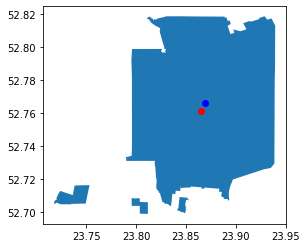

In [36]:
## Visualize intial guess (red) and geographical center (blue)
map = gdf.plot()
map.scatter(phi_deg,gamma_deg, c = 'red')
map.scatter(phi_cent_deg, gamma_cent_deg, c = 'blue')

It's almost the same as the center found after running through the algorithm for a single iteration, but it might take more iterations for a diffent landmass and depending on our initial guess.

---
---
## References

[1] Rogerson, Peter A. "A new method for finding geographic centers, with application to US States." The Professional Geographer 67.4 (2015): 686-694.

[2] Snyder, John Parr. Map projections--A working manual. Vol. 1395. US Government Printing Office, 1987.